In [1]:
import jax.numpy as jnp
import jax
import numpyro 
import numpyro.distributions as dist
from numpyro.infer.util import log_density
from numpyro.infer import NUTS, MCMC

import matplotlib.pyplot as plt

from experiments.targets import BLR
from projection_vi import ComponentwiseFlow, AffineFlow
from projection_vi.train import train, iterative_AS_mfvi
from projection_vi.flows import RealNVP

/mnt/home/sliu1/projection_VI/.venv_vi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
n = 20
d = 10

key = jax.random.key(2025)
cov_X = jnp.logspace(-1, 1, d)
key, subkey = jax.random.split(key)
U_ = jnp.linalg.qr(jax.random.normal(subkey, shape=(d, d)))[0]
cov_X = U_ @ jnp.diag(cov_X) @ U_.T
key, subkey = jax.random.split(key)
X = jax.random.multivariate_normal(subkey, mean=jnp.zeros(d), cov=cov_X, shape=(n,))

key, subkey = jax.random.split(key)
y = jax.random.bernoulli(subkey)

prior_scale = 2.

target = BLR(X, y, prior_scale=prior_scale)

## Run MCMC

In [37]:
num_warmup = 100
num_samples = 8000
num_chains = 1
thinning = 4

nuts_kernel = NUTS(target.numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, thinning=thinning)
mcmc.run(jax.random.key(0))

mcmc_samples = mcmc.get_samples()

param_names = target.param_unc_names()
samples_unc = None
for key in param_names:
    sample = mcmc_samples[key]
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)
    if samples_unc is None:
        samples_unc = sample
    else:
        samples_unc = jnp.concatenate([samples_unc, sample], axis=1)

mcmc_samples = target.param_constrain(samples_unc)
mcmc_samples = mcmc_samples.reshape(-1, d)

sample: 100%|██████████| 8100/8100 [00:36<00:00, 219.68it/s, 15 steps of size 1.90e-01. acc. prob=0.95]


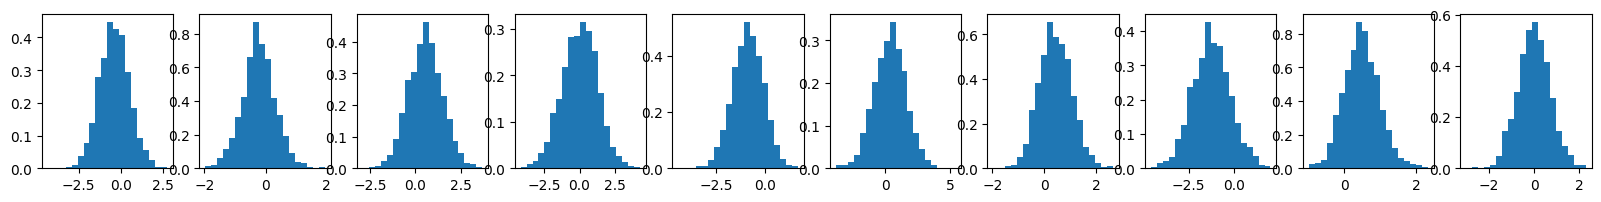

In [6]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 20, density=True)

## Laplace approximation

In [46]:
from jax.scipy.optimize import minimize

def neg_log_posterior(beta):
    return -target.log_prob(beta)

result = minimize(neg_log_posterior, x0=jnp.zeros(d), method='BFGS')
laplace_mean = result.x
laplace_cov = jnp.linalg.inv(jax.hessian(neg_log_posterior)(laplace_mean))
key, subkey = jax.random.split(key)
laplace_samples = jax.random.multivariate_normal(subkey, laplace_mean, laplace_cov, shape=(2000,))

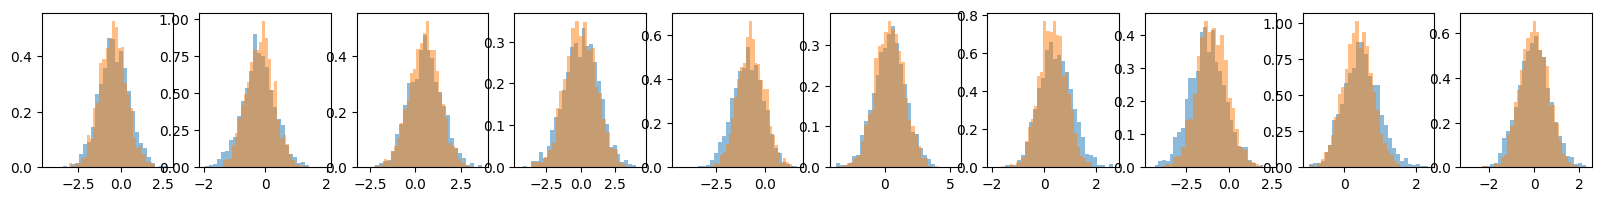

In [47]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
    ax[j].hist(laplace_samples[:, j], 30, density=True, alpha=.5)

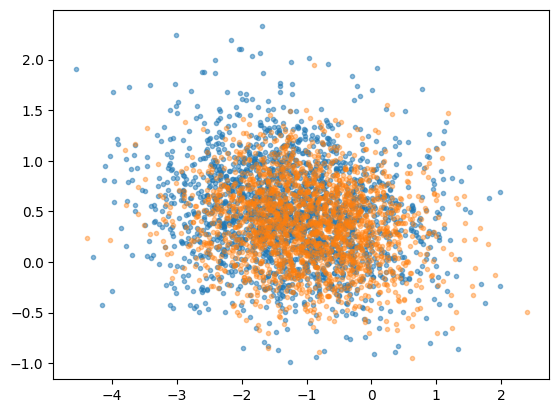

In [51]:
plt.scatter(mcmc_samples[:, 7], mcmc_samples[:, 8], marker='.', alpha=0.5)
plt.scatter(laplace_samples[:, 7], laplace_samples[:, 8], marker='.', alpha=0.4)

In [14]:
inverse_softplus = lambda x: jnp.log(jnp.exp(x) - 1.)

## MF Gaussian

In [15]:
@jax.jit
def logp_fn(x):
    return target.log_prob(x)

seed = 0
learning_rate = 1e-2
max_iter = 1000
n_train = 3000
n_val = 1000

affine_model = AffineFlow(d=d)
affine_params = affine_model.init(jax.random.key(0), jnp.zeros((1, d)))
key, subkey = jax.random.split(jax.random.key(seed))
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]

@jax.jit
def loss_fn(affine_params):
    return affine_model.apply(affine_params, base_samples, logp_fn, method=affine_model.reverse_kl)
affine_params, losses = train(loss_fn, affine_params, learning_rate=learning_rate, max_iter=max_iter)
shift = affine_params['params']['shift']
scale = jax.nn.softplus(affine_params['params']['scale_logit'] + inverse_softplus(1.))
transformed_samples = base_samples * scale + shift
# transformed_samples = target.param_constrain(transformed_samples)
moments_1_mf = jnp.mean(transformed_samples, 0)
moments_2_mf = jnp.mean(transformed_samples**2, 0)

scale = scale * 1.2

@jax.jit
def logp_fn_shifted(x):
    return logp_fn(x * scale + shift) + jnp.sum(jnp.log(scale))

2025-05-07 10:53:49.382907: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 10751.57it/s]


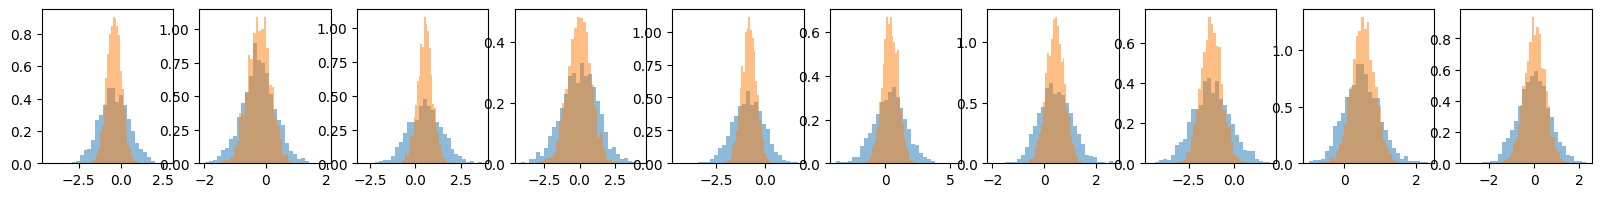

In [16]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
    ax[j].hist(transformed_samples[:, j], 30, density=True, alpha=.5)

## MF 

In [19]:
model = ComponentwiseFlow(d=d, num_bins=10, range_min=-5, range_max=5)
niter = 1
key, subkey = jax.random.split(key)
mf_samples, mf_val_samples, validation_results_mf = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank=0, weighted=False, rotate_first_iter=False)

2025-05-07 10:54:31.623183: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 9250.29it/s]


Iteration: 0 KL: 28.167124 ESS: 3.308046


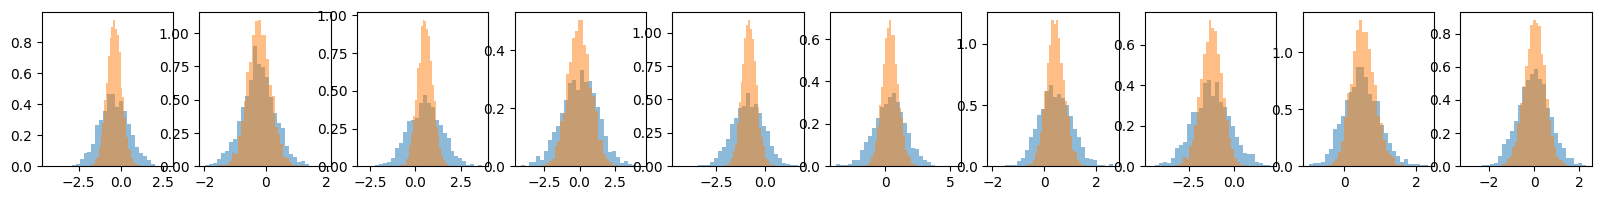

In [20]:
mf_samples_constrain = mf_samples[0] * scale + shift
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
    ax[j].hist(mf_samples_constrain[:, j], 30, density=True, alpha=.5)

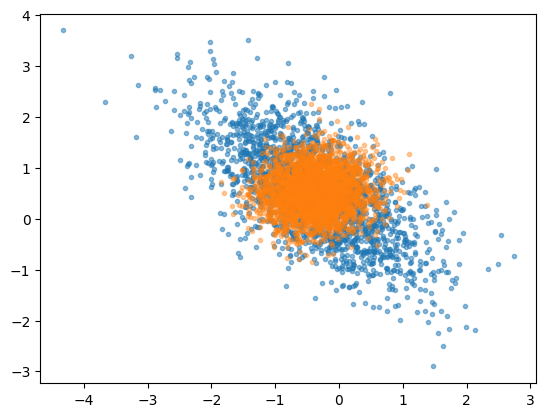

In [21]:
plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='.', alpha=0.5)
plt.scatter(mf_samples_constrain[:, 0], mf_samples_constrain[:, 2], marker='.', alpha=0.4)

## Projection by AS

In [27]:
model = ComponentwiseFlow(d=d, num_bins=15, range_min=-8, range_max=8)

niter = 1
key, subkey = jax.random.split(key)
AS_samples_hist, AS_val_samples_hist, validation_results_AS = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank=2, weighted=False)

2025-05-07 10:55:41.575576: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 8417.75it/s]


eigenvalues [2.338034   0.40890914 0.38629967 0.3041906  0.26275524 0.23513693
 0.22210063 0.21040861 0.1481883  0.09327543]
Iteration: 0 KL: 24.923449 ESS: 494.51196


In [28]:
samples_constrain = AS_samples_hist[-1] * scale + shift

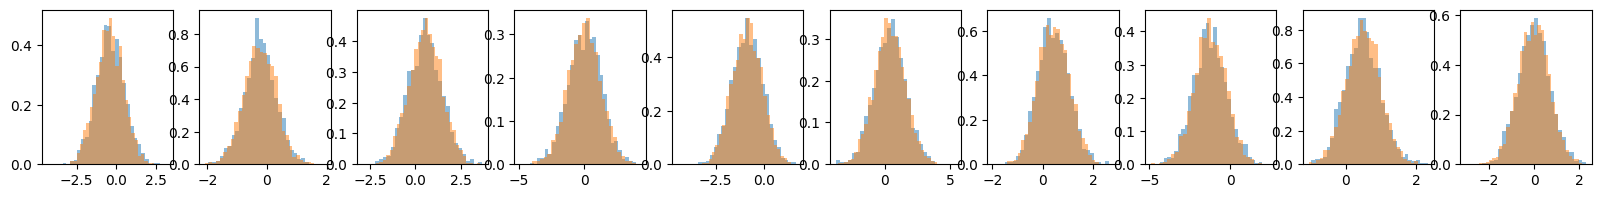

In [29]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
    ax[j].hist(samples_constrain[:, j], 30, density=True, alpha=.5)

In [30]:
jnp.mean((jnp.mean(samples_constrain, 0) - jnp.mean(mcmc_samples, 0))**2), jnp.mean((jnp.mean(samples_constrain**2, 0) - jnp.mean(mcmc_samples**2, 0))**2)

(Array(0.00044181, dtype=float32), Array(0.00524709, dtype=float32))

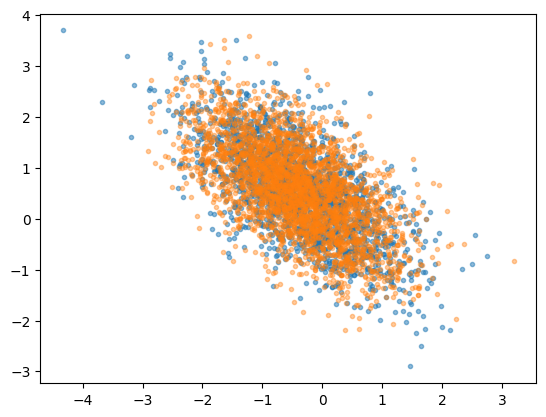

In [31]:
plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='.', alpha=0.5)
plt.scatter(samples_constrain[:, 0], samples_constrain[:, 2], marker='.', alpha=0.4)

## Random projection

In [32]:

key, subkey = jax.random.split(key)
RP_samples_hist, RP_val_samples_hist, validation_results_RP = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank=0, weighted=False)

2025-05-07 10:56:11.057182: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 8429.12it/s]


Iteration: 0 KL: 27.616007 ESS: 14.990441


In [33]:
RP_samples_constrain = RP_samples_hist[-1] * scale + shift

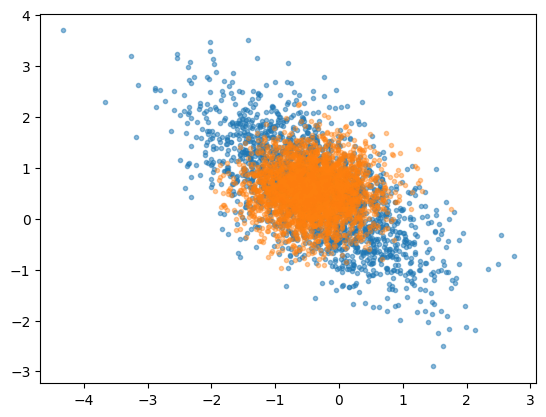

In [34]:
plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='.', alpha=0.5)
plt.scatter(RP_samples_constrain[:, 0], RP_samples_constrain[:, 2], marker='.', alpha=0.4)

## Fit RealNVP

In [68]:
model_nvp = RealNVP(dim=d, n_layers=2, hidden_dims=[d])
params_nvp = model_nvp.init(jax.random.key(0), jnp.zeros((1, d)))

@jax.jit
def loss_nvp(params_nvp):
    return model_nvp.apply(params_nvp, base_samples, logp_fn, method=model_nvp.reverse_kl)

params_nvp, losses_nvp = train(loss_nvp, params_nvp, learning_rate=1e-2, max_iter=500)

2025-05-07 09:52:12.552235: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 500 iterations: 100%|██████████| 500/500 [00:00<00:00, 2658.52it/s]


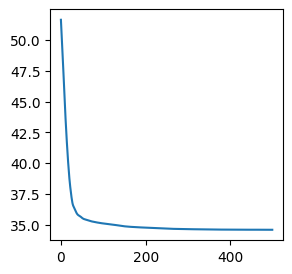

In [69]:
plt.figure(figsize=(3, 3))
plt.plot(losses_nvp)

In [70]:
transformed_samples_nvp, logdet_nvp = model_nvp.apply(params_nvp, base_samples, method=model_nvp.forward)
transformed_samples_nvp.mean(0), jnp.mean(transformed_samples_nvp**2, 0)


(Array([-0.01915337, -0.10682428,  0.1639872 ,  0.0471459 , -0.40818486,
         0.02563343,  0.25197783, -0.6048824 ,  0.34019107, -0.00536918],      dtype=float32),
 Array([0.36323225, 0.1850542 , 0.3994182 , 0.66544807, 0.45019487,
        0.59898263, 0.2629037 , 0.81820375, 0.26971287, 0.30513766],      dtype=float32))

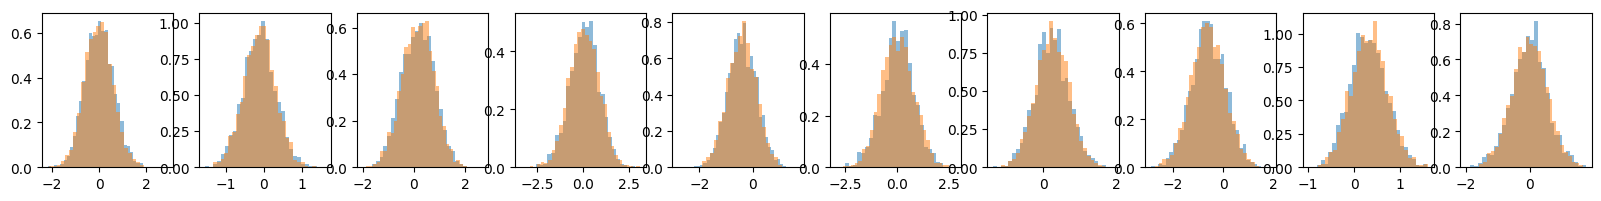

In [71]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=0.5)
    ax[j].hist(transformed_samples_nvp[:, j], 30, density=True, alpha=.5)

In [67]:
jnp.mean((jnp.mean(transformed_samples_nvp, 0) - jnp.mean(mcmc_samples, 0))**2), jnp.mean((jnp.mean(transformed_samples_nvp**2, 0) - jnp.mean(mcmc_samples**2, 0))**2)

(Array(0.07579779, dtype=float32), Array(0.5407337, dtype=float32))

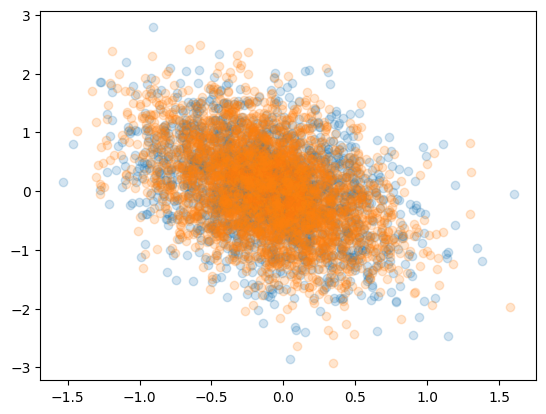

In [88]:
j1 = 1
j2 = 5
plt.scatter(mcmc_samples[:, j1], mcmc_samples[:, j2], alpha=0.2)
plt.scatter(transformed_samples_nvp[:, j1], transformed_samples_nvp[:, j2], alpha=0.2)